In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import dates as mdates
import seaborn as sns
from wordcloud import WordCloud

from stop_words import get_stop_words
from collections import Counter
from textblob import TextBlob

## Importing data

In [2]:
obe_df = pd.read_csv("D:\\DataSets\\trip_advisor\\The_Oberoi_Mumbai_V2.csv").drop_duplicates()
taj_df = pd.read_csv("D:\\DataSets\\trip_advisor\\taj_mahal_palace_mumbai_V2.csv").drop_duplicates()

combined = [obe_df, taj_df]

## Cleaning/feature extraction

In [3]:
for df in combined:
    df.rename(columns={'contributions': 'user_contributions'}, inplace=True)
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['user_rating'] = df['user_rating']/10
    df['is_satisfied'] = 0
    df['review_length'] = df['review_body'].str.len()
    df.loc[df['user_rating'] > 3, 'is_satisfied'] = 1
    
    df['trip_type'] = df['trip_type'].str.split(' ').str[-1]
    
    df['user_city'], df['user_country'] = df['user_location'].str.split(',').str[0].str.strip(), df['user_location'].str.split(',').str[1].str.strip()
    df.loc[df['user_location'].str.contains(',') == False, 'user_country'] = df['user_city']
    
    df['is_domestic'] = 0
    df.loc[df['user_country'] == 'India', 'is_domestic'] = 1
    df.loc[df['user_country'].isna(), 'is_domestic'] = -1
    df.sort_values('review_date', ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.drop(['Unnamed: 0', 'user_location'], axis=1, inplace=True)
    df.set_index('review_date', inplace=True)
    
main_df = taj_df.append(obe_df)

In [4]:
main_df.head()

,hotel_name,review_body,user_contributions,helpful_vote,user_rating,trip_type,is_satisfied,review_length,user_city,user_country,is_domestic
review_date,,,,,,,,,,,
2019-03-02,"The Taj Mahal Palace, Mumbai",Staying at the Taj is as good as hotel travel ...,13,3,5.0,couple,1,933,San Francisco,California,0
2019-03-02,"The Taj Mahal Palace, Mumbai",I stayed in Mumbai for six nights in a 3 star ...,1,0,5.0,solo,1,367,Melbourne,Australia,0
2019-03-02,"The Taj Mahal Palace, Mumbai",Lovely experience. Beautiful interiors - retai...,1,0,5.0,family,1,247,NaN,NaN,-1
2019-03-02,"The Taj Mahal Palace, Mumbai",Experiencing this fantastic classic hotel is a...,3,0,5.0,friends,1,230,Hamburg,Germany,0
2019-03-02,"The Taj Mahal Palace, Mumbai",Stayed here for 9 nights. Check-in was little ...,18,4,5.0,business,1,814,NaN,NaN,-1


## Combined Hotels EDA

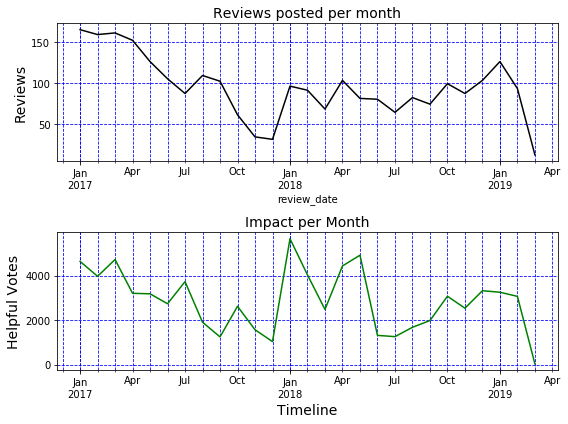

In [5]:
def plot_per_month(df):
    
    month = df[df.index > '2017'].copy()
    month['is_post'] = 1
    month = month.resample('M').sum().dropna()
    
    plt.subplot(211)
    month['is_post'].plot(figsize=(8, 6), color='k')
    plt.ylabel('Reviews', fontsize=14)
    plt.title('Reviews posted per month', fontsize=14)
    plt.grid(b=True, which='major', color='b', linestyle='--')
    plt.grid(b=True, which='minor', color='b', linestyle='--')
    
    plt.subplot(212)
    month['helpful_vote'].plot(figsize=(8, 6), color='g')
    plt.xlabel('Timeline', fontsize=14)
    plt.ylabel('Helpful Votes', fontsize=14)
    plt.title('Impact per Month', fontsize=14)
    plt.grid(b=True, which='major', color='b', linestyle='--')
    plt.grid(b=True, which='minor', color='b', linestyle='--')
    plt.tight_layout()
    plt.show()
    
plot_per_month(main_df)

### Top Contributors by Country

In [6]:
main_df['user_country'].value_counts().head()

India                   1446
United Kingdom          1363
Australia                291
United Arab Emirates     162
New York                 149
Name: user_country, dtype: int64

### Top Contributors by Indian City

In [7]:
main_df[main_df['user_country']=='India']['user_city'].value_counts().head()

Mumbai                535
New Delhi             191
Pune                   70
Bengaluru              70
Gurugram (Gurgaon)     34
Name: user_city, dtype: int64

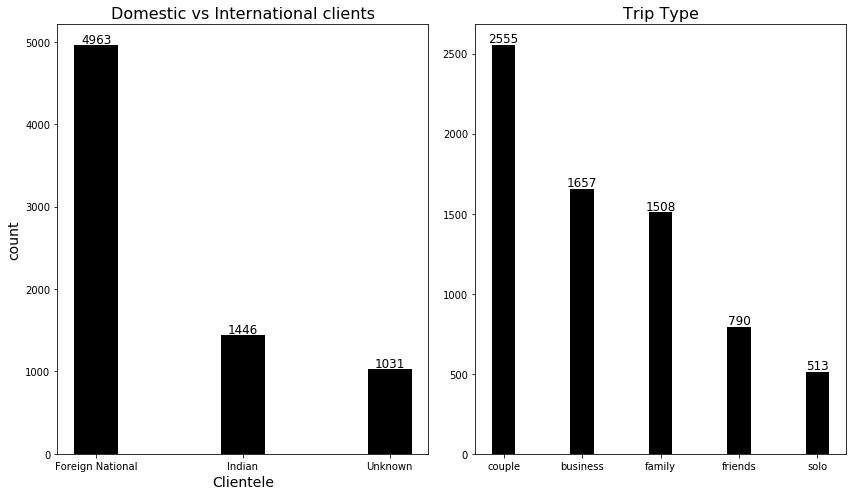

In [85]:
def plot_client_count(df, savefig=None):

    plt.figure(figsize=(12, 7))
    
    plt.subplot(121)
    x = ['Foreign National', 'Indian', 'Unknown']
    y = np.array(df['is_domestic'].value_counts())

    plt.bar(x, y, color='k', width=0.3)

    for a,b in zip(x, y):
        plt.text(a, b + 17, str(b), fontsize=12, horizontalalignment='center')

    plt.title('Domestic vs International clients', fontsize=16)
    plt.xlabel('Clientele', fontsize=14)
    plt.ylabel('count', fontsize=14)
    
    plt.subplot(122)
    x = df['trip_type'].value_counts().index
    y = np.array(df['trip_type'].value_counts())
        
    plt.bar(x, y, color='k', width=0.3)
    
    for a,b in zip(x, y):
        plt.text(a, b + 17, str(b), fontsize=12, horizontalalignment='center')

    plt.title('Trip Type', fontsize=16)
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f"D:\\DataSets\\trip_advisor\\{savefig}.jpg", dpi=300)
    plt.show()
    
plot_client_count(main_df)

In [73]:
main_df['review_length'].describe()

count    7440.000000
mean      626.936559
std       598.514974
min        51.000000
25%       272.000000
50%       425.000000
75%       757.000000
max      9856.000000
Name: review_length, dtype: float64

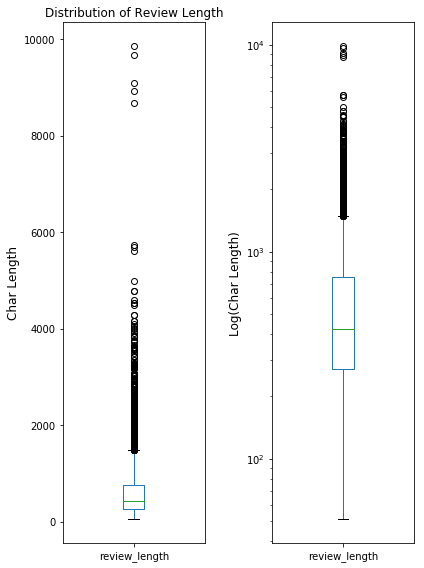

In [74]:
plt.figure(figsize=(6, 8))

plt.subplot(121)
main_df['review_length'].plot(kind='box')
plt.title('Distribution of Review Length')
plt.ylabel('Char Length', fontsize=12)

plt.subplot(122)
main_df['review_length'].plot(kind='box', logy=True)
plt.ylabel('Log(Char Length)', fontsize=12)

plt.tight_layout()
plt.show()

After removing outliers:

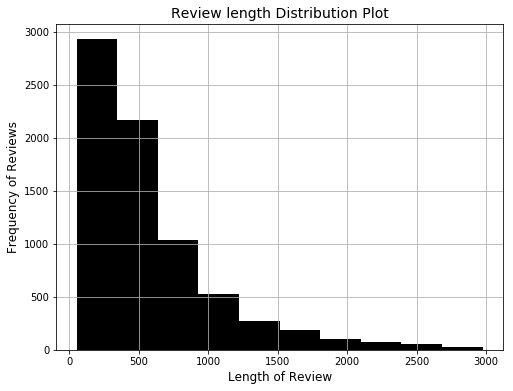

This histogram contains 98.98 percent of our data


In [75]:
plt.figure(figsize=(8, 6))
value1, value2 = main_df['review_length'].quantile([0, 0.99])

main_df[(main_df['review_length'] > value1) & (main_df['review_length'] < value2)]['review_length'].hist(color='k')
pct = len(main_df[(main_df['review_length'] > value1) & (main_df['review_length'] < value2)])/len(main_df)

plt.xlabel('Length of Review', fontsize=12)
plt.ylabel('Frequency of Reviews', fontsize=12)
plt.title('Review length Distribution Plot', fontsize=14)
plt.show()

print(f"This histogram contains {round(pct*100, 2)} percent of our data")

Looks like it's typical for users to post reviews with character length 1000 or less. We'll analyse a few outliers (above 2000 characters).

# Taj EDA

In [12]:
taj_df.head()

,hotel_name,review_body,user_contributions,helpful_vote,user_rating,trip_type,is_satisfied,review_length,user_city,user_country,is_domestic
review_date,,,,,,,,,,,
2019-03-02,"The Taj Mahal Palace, Mumbai",Staying at the Taj is as good as hotel travel ...,13,3,5.0,couple,1,933,San Francisco,California,0
2019-03-02,"The Taj Mahal Palace, Mumbai",I stayed in Mumbai for six nights in a 3 star ...,1,0,5.0,solo,1,367,Melbourne,Australia,0
2019-03-02,"The Taj Mahal Palace, Mumbai",Lovely experience. Beautiful interiors - retai...,1,0,5.0,family,1,247,NaN,NaN,-1
2019-03-02,"The Taj Mahal Palace, Mumbai",Experiencing this fantastic classic hotel is a...,3,0,5.0,friends,1,230,Hamburg,Germany,0
2019-03-02,"The Taj Mahal Palace, Mumbai",Stayed here for 9 nights. Check-in was little ...,18,4,5.0,business,1,814,NaN,NaN,-1


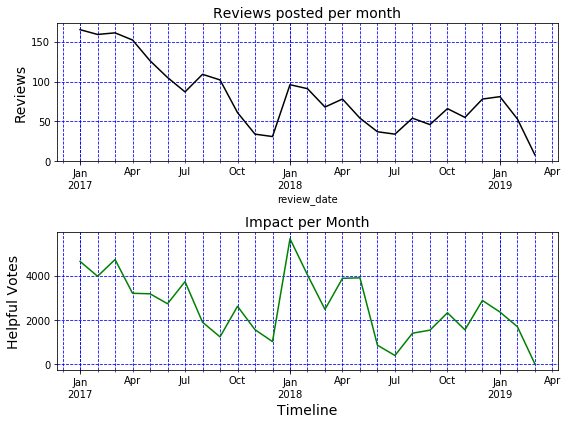

In [13]:
plot_per_month(taj_df)

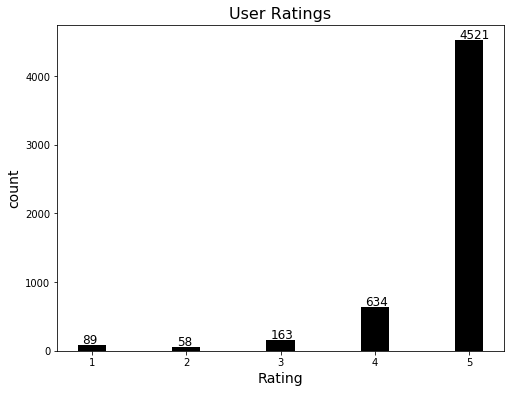

In [76]:
def plot_user_ratings(df, savefig=None):
    """
    Count of user ratings
    """

    plt.figure(figsize=(8, 6))

    x = [1, 2, 3, 4, 5]
    y = [len(df[df['user_rating'] == 1]), len(df[df['user_rating'] == 2]), 
          len(df[df['user_rating'] == 3]), len(df[df['user_rating'] == 4]), len(df[df['user_rating'] == 5])]

    plt.bar(x, y, color='k', width=0.3)

    for a,b in zip(x, y):
        plt.text(a - 0.1, b + 20, str(b), fontsize=12)

    plt.title('User Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=14)
    plt.ylabel('count', fontsize=14)
    if savefig:
        plt.savefig(f"D:\\DataSets\\trip_advisor\\{savefig}.jpg", dpi=300)
    plt.show()
    
plot_user_ratings(taj_df)

We've assumed all users who have rated the hotel above 3 (out of 5) are satisfied.


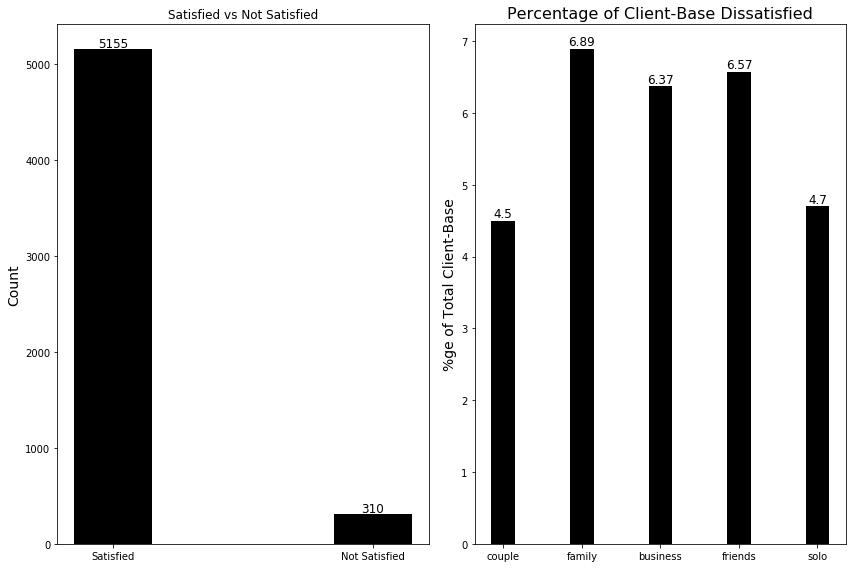

In [77]:
def plot_is_satisfied(df, savefig=None):
    print("We've assumed all users who have rated the hotel above 3 (out of 5) are satisfied.")
    plt.figure(figsize=(12, 8))

    plt.subplot(121)
    x = ['Satisfied', 'Not Satisfied']
    y = [len(df[df['is_satisfied'] == 1]), len(df[df['is_satisfied'] == 0])]

    plt.bar(x, y, color='k', width=0.3)

    for a,b in zip(x, y):
        plt.text(a, b + 20, str(b), fontsize=12, horizontalalignment='center')

    plt.ylabel('Count', fontsize=14)
    plt.title("Satisfied vs Not Satisfied")
    
    plt.subplot(122)
    not_sat = df[df['is_satisfied'] == 0]
    x = not_sat['trip_type'].value_counts().index
    y = (np.array(not_sat['trip_type'].value_counts())/np.array(df['trip_type'].value_counts()))*100
    y = np.round(y, 2)
    plt.bar(x, y, color='k', width=0.3)
    
    for a,b in zip(x, y):
        plt.text(a, b + 0.05, str(b), fontsize=12, horizontalalignment='center')
    
    plt.ylabel("%ge of Total Client-Base", fontsize=14)
    plt.title('Percentage of Client-Base Dissatisfied', fontsize=16)
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f"D:\\DataSets\\trip_advisor\\{savefig}.jpg", dpi=300)
    plt.show()

plot_is_satisfied(taj_df)

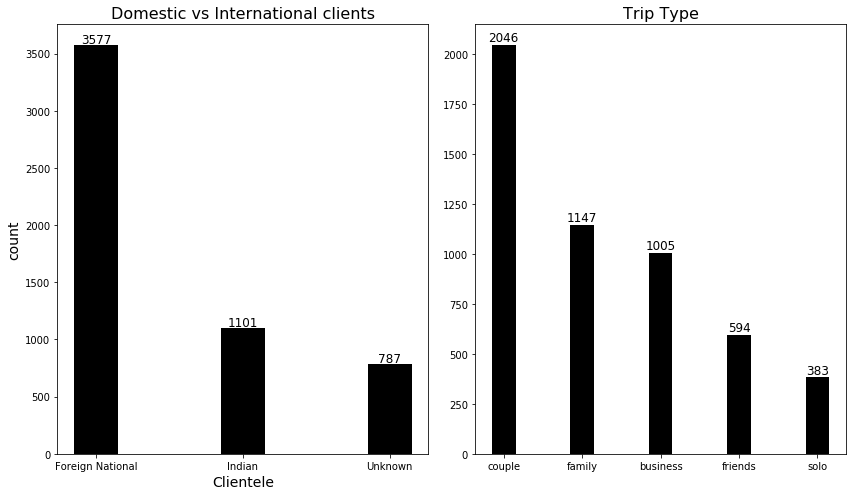

In [101]:
plot_client_count(taj_df, savefig='dom_vs_int_taj')

## International Guests

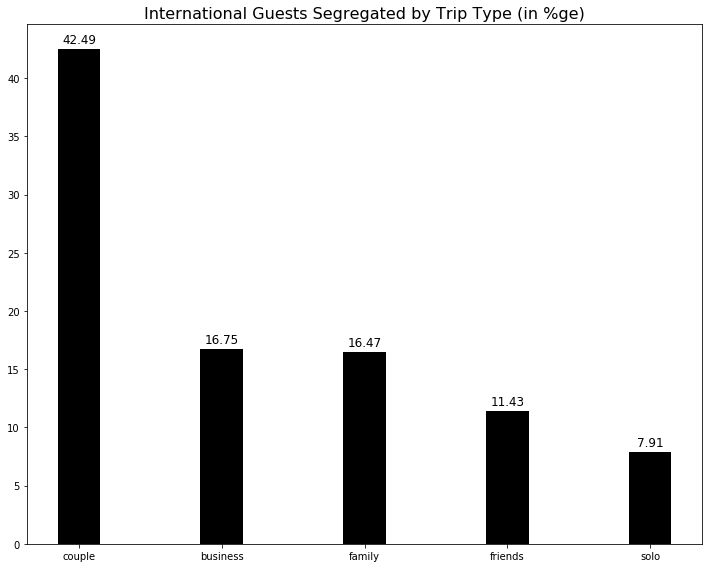

In [87]:
guest = taj_df[taj_df['is_domestic'] == 0]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('International Guests Segregated by Trip Type (in %ge)', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\int_pct_taj.jpg", dpi=300)
plt.show()

## Domestic Guests - Including Mumbai

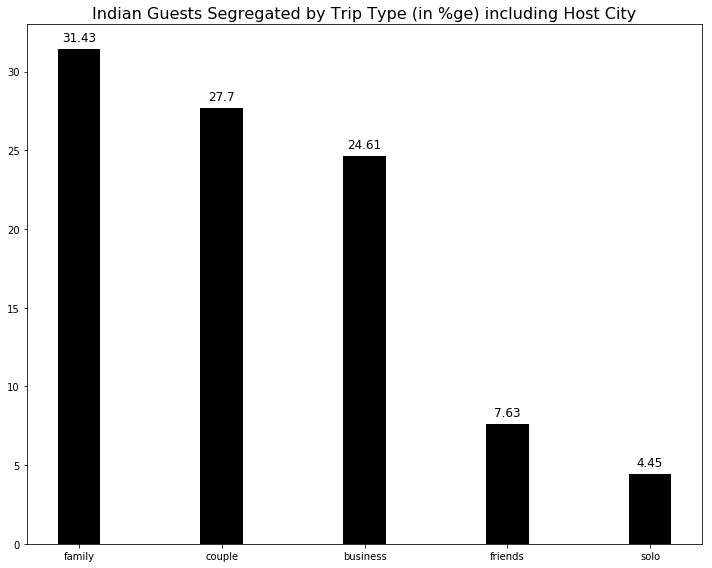

In [88]:
guest = taj_df[taj_df['is_domestic'] == 1]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Indian Guests Segregated by Trip Type (in %ge) including Host City', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\dom_pct_taj.jpg", dpi=300)
plt.show()

## Domestic Guests - Excluding Mumbai

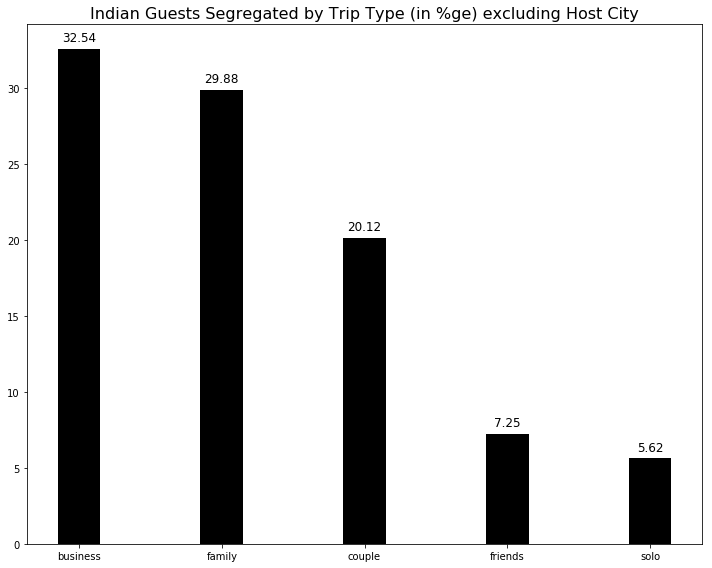

In [89]:
guest = taj_df[(taj_df['is_domestic'] == 1) & (taj_df['user_city'] != 'Mumbai')]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Indian Guests Segregated by Trip Type (in %ge) excluding Host City', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\dom_pct_taj2.jpg", dpi=300)
plt.show()

## Guests from Mumbai

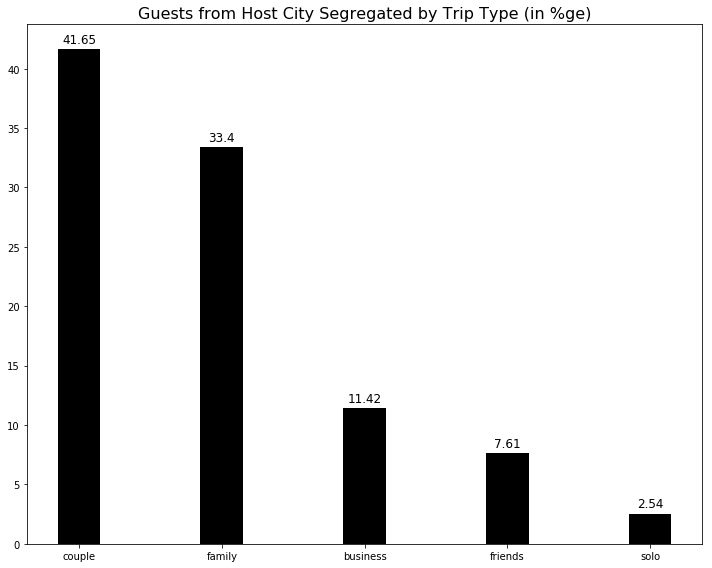

In [90]:
guest = taj_df[(taj_df['user_city'] == 'Mumbai')]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Guests from Host City Segregated by Trip Type (in %ge)', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\idom_pct_taj3.jpg", dpi=300)
plt.show()

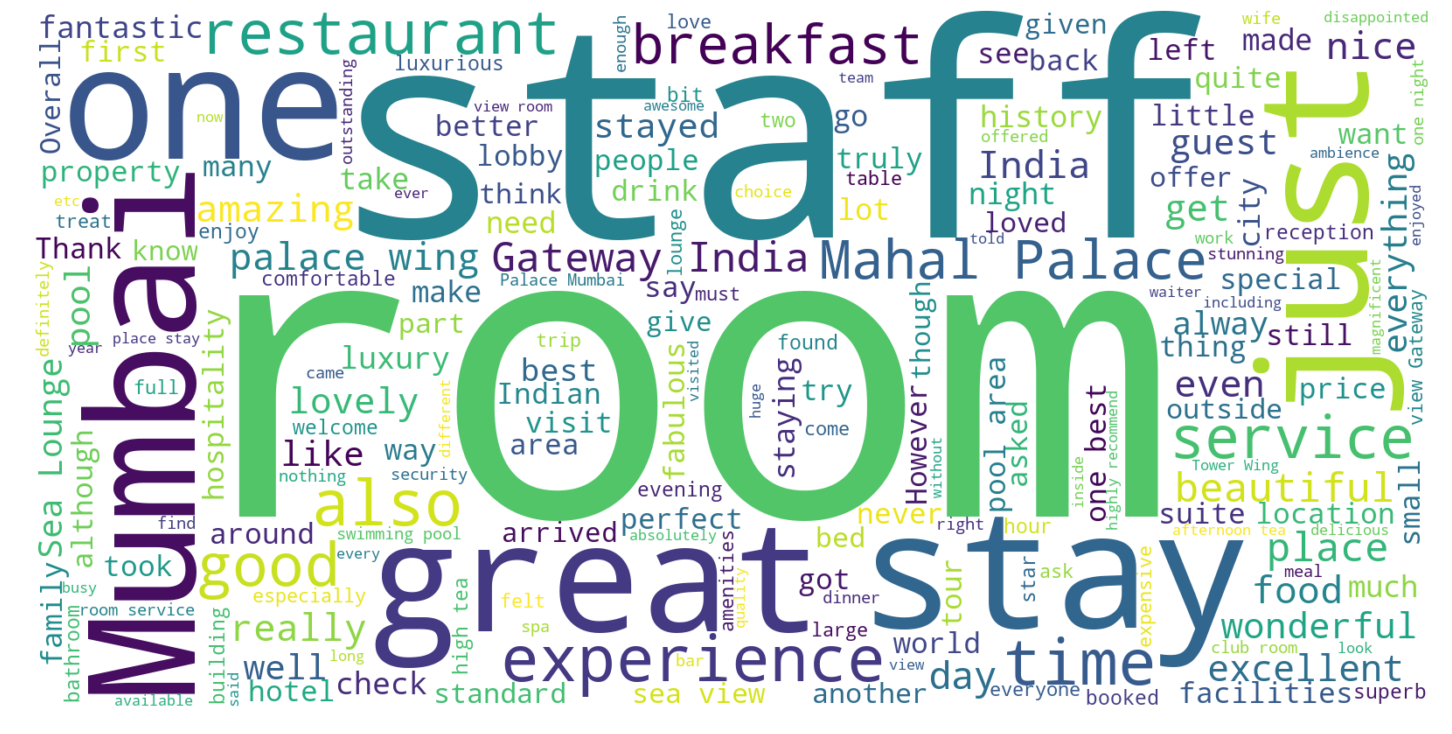

In [99]:
def create_wordcloud(df, col, savefig=None):
    # Create the wordcloud object
    
    stop = get_stop_words('en') + ['hotel', 'can', 'will', 'us', 'went', 'taj']
    wordcloud = WordCloud(width=1600, height=800, stopwords=stop, min_font_size=6, background_color='white').generate(' '.join(df[col].fillna('')))

    # Display the generated image:
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=0)
    if savefig:
        plt.savefig(f"D:\\DataSets\\trip_advisor\\{savefig}.jpg", dpi=300)
    plt.show()
    
create_wordcloud(df=taj_df, col='review_body')

In [20]:
def clean_review(text):
    for ch in ['\\','`','*','_','{','}','[',']','(',')','>','#','+','-','.','!','$','\'', ',', '"']:
        if ch in text:
            text = text.replace(ch, '')
    
    return text.lower()

def analyze_sentiment(text):
    analysis = TextBlob(text)
    
    if analysis.sentiment.polarity > 0:
        return 1
    
    elif analysis.sentiment.polarity == 0:
        return 0
    
    else:
        return -1
    

In [21]:
taj_df['sentiment'] = taj_df['review_body'].apply(lambda row: analyze_sentiment(clean_review(row)))

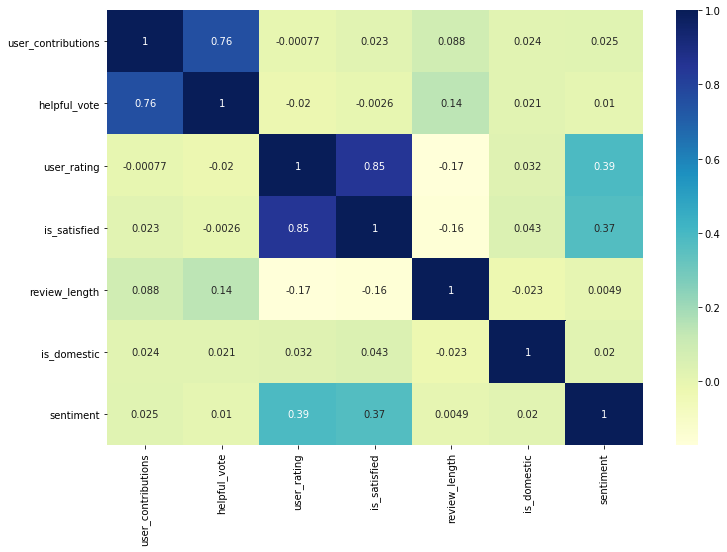

In [22]:
def plot_corr(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
    plt.show()
    
plot_corr(taj_df)

1) There's good correlation between people who contribute frequently and tendency of their review being helpful.

2) As expected, there's a slight __positive correlation__ between user_ratings, satisfaction and sentiment. 

### Reviews with negative sentiment but good rating (4, 5): 

#### These are reviews that may go overlooked because they are masked by a good rating, or are mislabeled false positives.

In [23]:
def get_neg_reviews(df, sentiment=-1, satisfied=0):
    bad_reviews = df[(df['sentiment'] == sentiment) & (df['is_satisfied'] == satisfied)].sort_index(ascending=False)

    for review, rating, date, impact, t_type, loc in zip(bad_reviews['review_body'], bad_reviews['user_rating'], bad_reviews.index, bad_reviews['helpful_vote'], bad_reviews['trip_type'], bad_reviews['user_country']):
        print(f"\n--Review--\n\nDate Posted: {date}\nRating: {rating}\nTrip Type: {t_type}\nImpact: {impact}\nUser Country: {loc}\n\n{review}\n")
        
get_neg_reviews(taj_df, -1, 1)


--Review--

Date Posted: 2019-02-18 00:00:00
Rating: 4.0
Trip Type: couple
Impact: 0
User Country: United Kingdom

THe Taj Mahal Palace was a dream and most of it was fulfilled by its location, its rooms - or suites in our case - and the cleanliness and fabulous bed linen. However, we were greatly disappointed wtih the slow and inefficient service at breakfast.


--Review--

Date Posted: 2019-01-29 00:00:00
Rating: 4.0
Trip Type: friends
Impact: 0
User Country: India

Staying at the Taj was a dream.Had booked the tower with the city view with a request for the gateway view which is chargeable which Booking apps do not show.Upgraded to taj palace but room location wasn’t great.The room, service, staff was brilliant.Breakfast buffet was a disappointment as there is waiting & the buffet spread is just like any hotel or maybe less , also staff here not very welcoming.


--Review--

Date Posted: 2019-01-25 00:00:00
Rating: 5.0
Trip Type: couple
Impact: 74
User Country: greece

We Had lunch

### Reviews with bad sentiment and bad rating (3 and below):

In [24]:
get_neg_reviews(taj_df)


--Review--

Date Posted: 2019-02-26 00:00:00
Rating: 2.0
Trip Type: couple
Impact: 10
User Country: United Kingdom

I dont usually review places I've stayed, but this requires a review...Since I booked the Taj in Dec 2018, the team at Taj have made error after error after error.Here are some of them:Extremely poor internal communication and high staff turnover - lead to some monumental cock ups that that will never be put right - essentially, they ruined my proposal to my now Fiancee Booked the palace, got the tower... when asked about this, they claim to have 'upgraded' us into a cheaper room.Cleanliness is appalling, theres rubble on the bathroom floor... i wouldn't expect this from Tra velodge, let alone one of the most prestigious brands in the world.All in all 2 out of 5 would be generous. Do yourselves a favour, save the money and book somewhere that will care.


--Review--

Date Posted: 2019-02-15 00:00:00
Rating: 1.0
Trip Type: business
Impact: 175
User Country: United Kingdom

# Oberoi EDA

In [25]:
obe_df.head()

,hotel_name,review_body,user_contributions,helpful_vote,user_rating,trip_type,is_satisfied,review_length,user_city,user_country,is_domestic
review_date,,,,,,,,,,,
2019-03-03,"The Oberoi, Mumbai",Very comfortable hotel.excellent service and h...,2,0,5.0,business,1,331,NaN,NaN,-1
2019-03-01,"The Oberoi, Mumbai",wonderful location. u wont be able to find a b...,4,0,5.0,couple,1,252,Ahmedabad,India,1
2019-03-01,"The Oberoi, Mumbai",Exceptional stay in fabulous location at Narim...,1,0,5.0,couple,1,306,NaN,NaN,-1
2019-03-01,"The Oberoi, Mumbai",I can't say enough about how incredible our st...,3,1,5.0,couple,1,773,NaN,NaN,-1
2019-02-27,"The Oberoi, Mumbai",Great location with super staff at every level...,184,92,5.0,couple,1,499,Tel Aviv,Israel,0


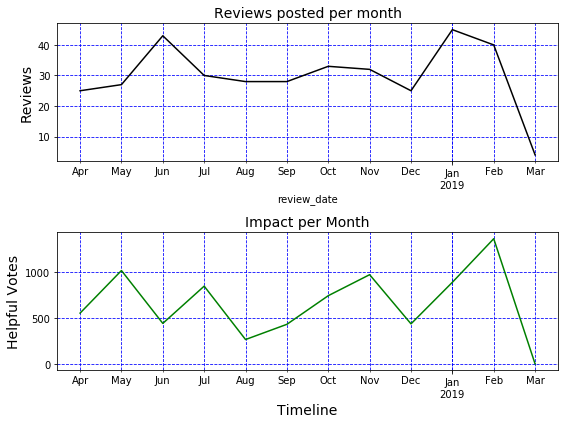

In [29]:
plot_per_month(obe_df)

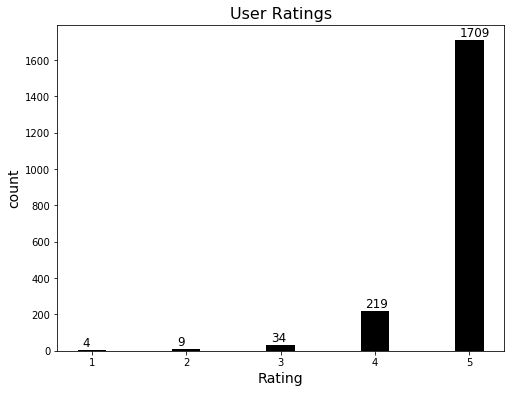

In [92]:
plot_user_ratings(obe_df, savefig='oberoi_ratings')

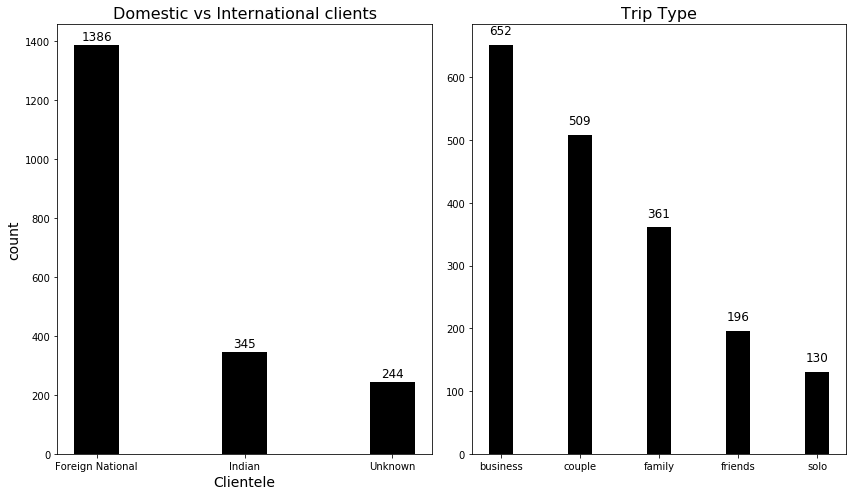

In [103]:
plot_client_count(obe_df, savefig='dom_vs_int_oberoi')

We've assumed all users who have rated the hotel above 3 (out of 5) are satisfied.


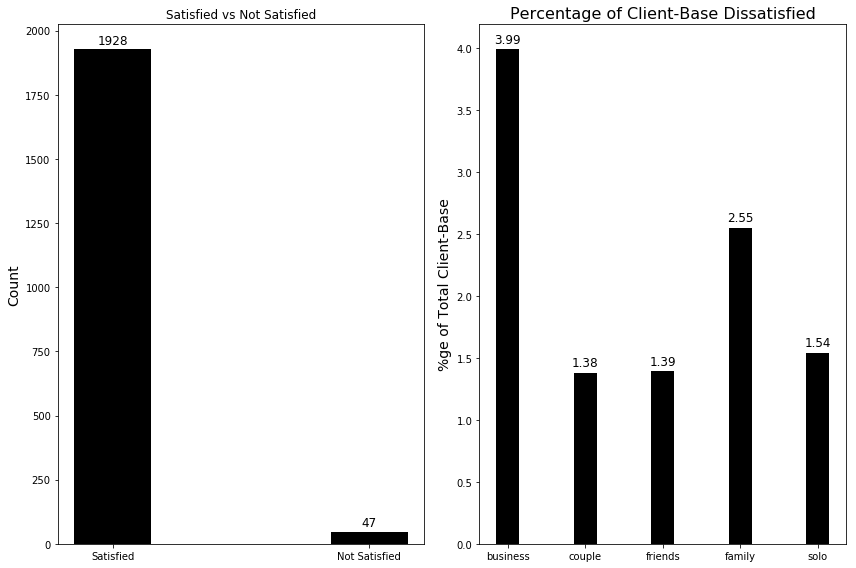

In [94]:
plot_is_satisfied(obe_df, 'satisfaction_oberoi')

## International Guests

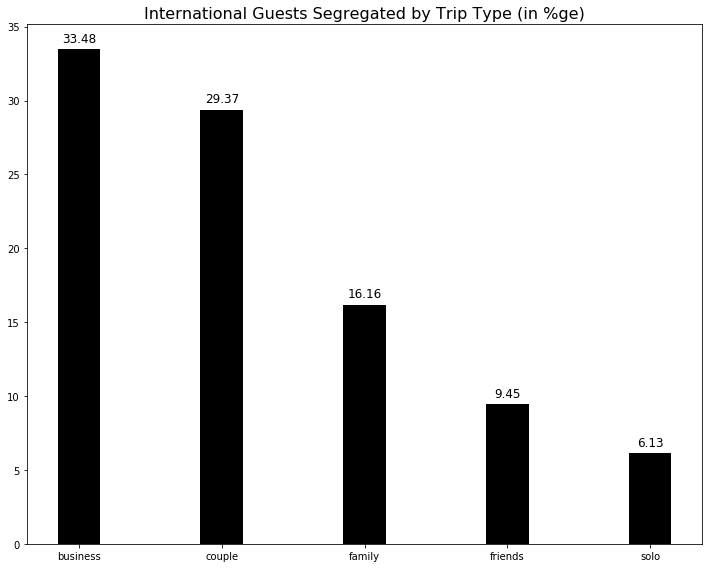

In [95]:
guest = obe_df[obe_df['is_domestic'] == 0]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('International Guests Segregated by Trip Type (in %ge)', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\int_pct_oberoi.jpg", dpi=300)
plt.show()

## Domestic Guests - Including Mumbai

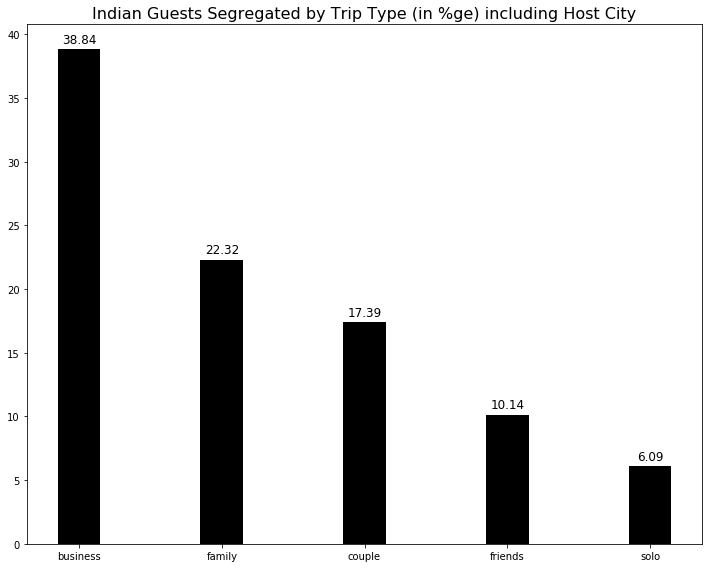

In [96]:
guest = obe_df[obe_df['is_domestic'] == 1]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Indian Guests Segregated by Trip Type (in %ge) including Host City', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\int_pct_oberoi2.jpg", dpi=300)
plt.show()

## Domestic Guests - Excluding Mumbai

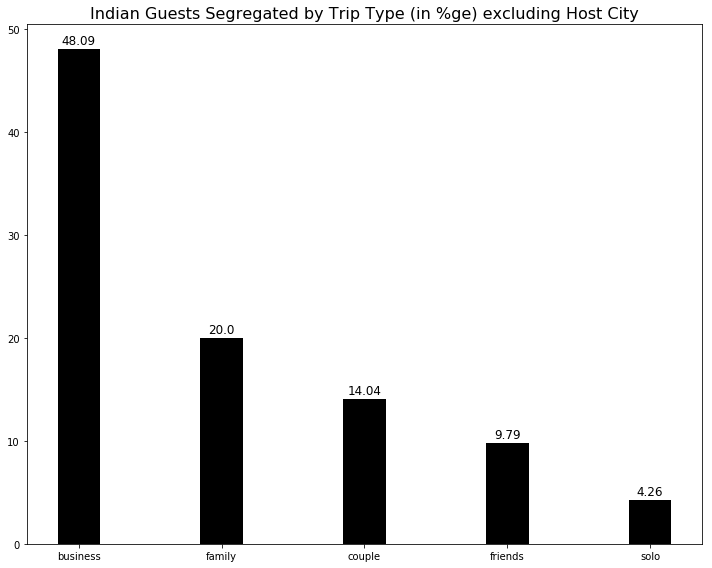

In [97]:
guest = obe_df[(obe_df['is_domestic'] == 1) & (obe_df['user_city'] != 'Mumbai')]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Indian Guests Segregated by Trip Type (in %ge) excluding Host City', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\int_pct_oberoi3.jpg", dpi=300)
plt.show()

## Guests from Mumbai

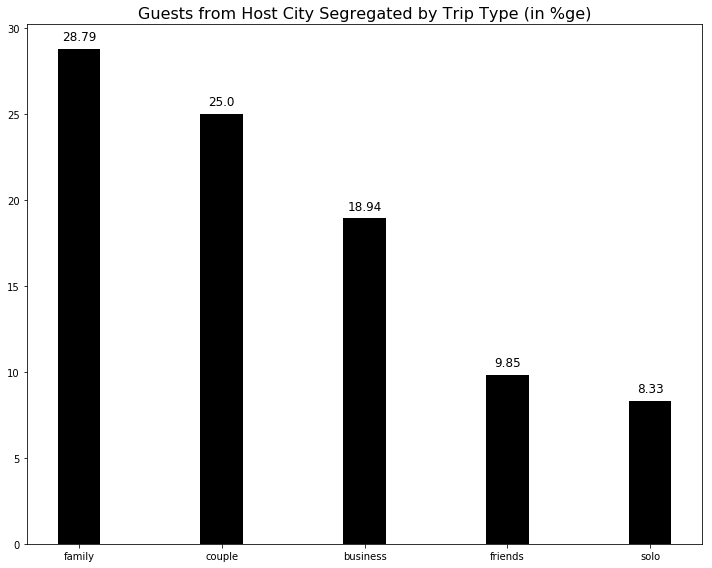

In [98]:
guest = obe_df[(obe_df['user_city'] == 'Mumbai')]

plt.figure(figsize=(10, 8))
x = guest['trip_type'].value_counts().index
y = np.array(guest['trip_type'].value_counts())/len(guest)*100
y = np.round(y, 2)

plt.bar(x, y, color='k', width=0.3)

for a,b in zip(x, y):
    plt.text(a, b + 0.5, str(b), fontsize=12, horizontalalignment='center')

plt.title('Guests from Host City Segregated by Trip Type (in %ge)', fontsize=16)

plt.tight_layout()
plt.savefig(f"D:\\DataSets\\trip_advisor\\dom_pct_oberoi3.jpg", dpi=300)
plt.show()

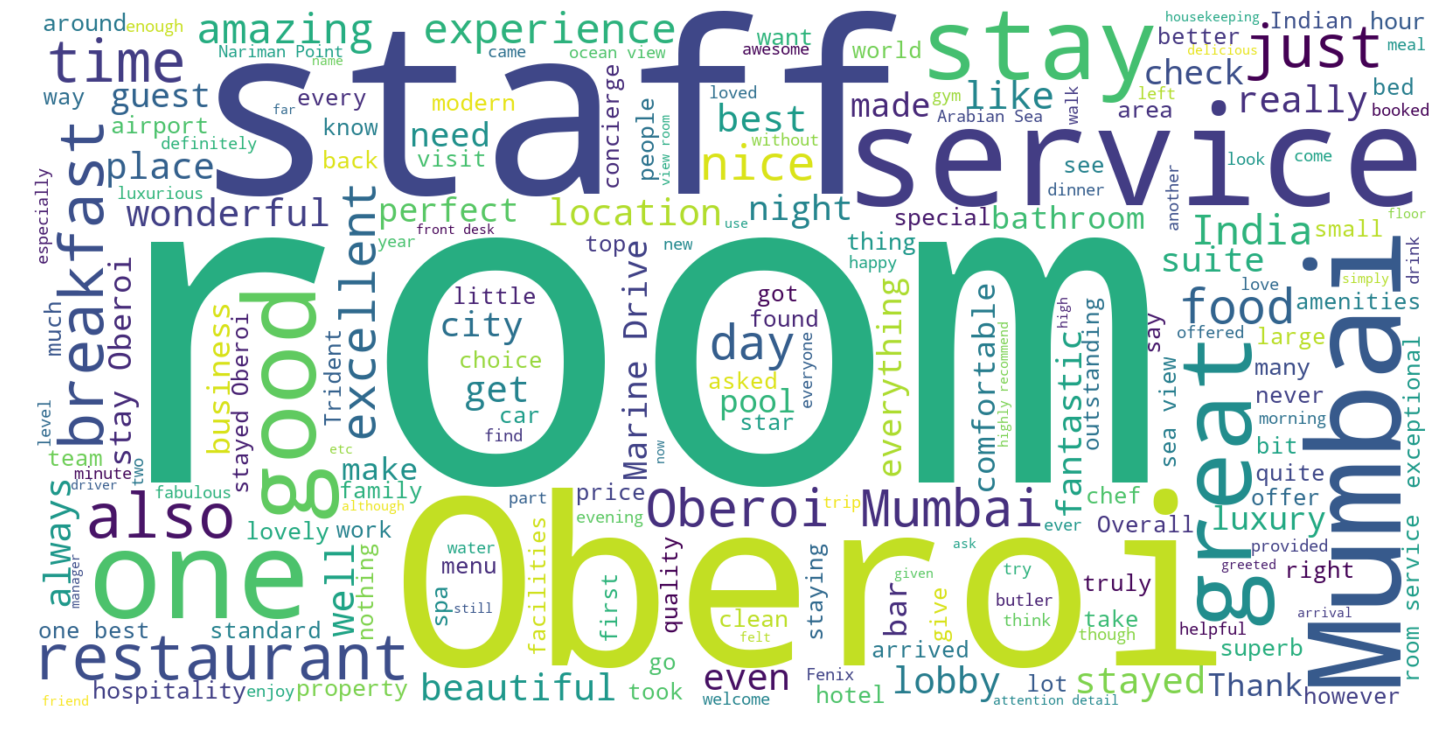

In [100]:
create_wordcloud(obe_df, 'review_body', savefig='oberoi_cloud')

In [31]:
obe_df['sentiment'] = obe_df['review_body'].apply(lambda row: analyze_sentiment(clean_review(row)))

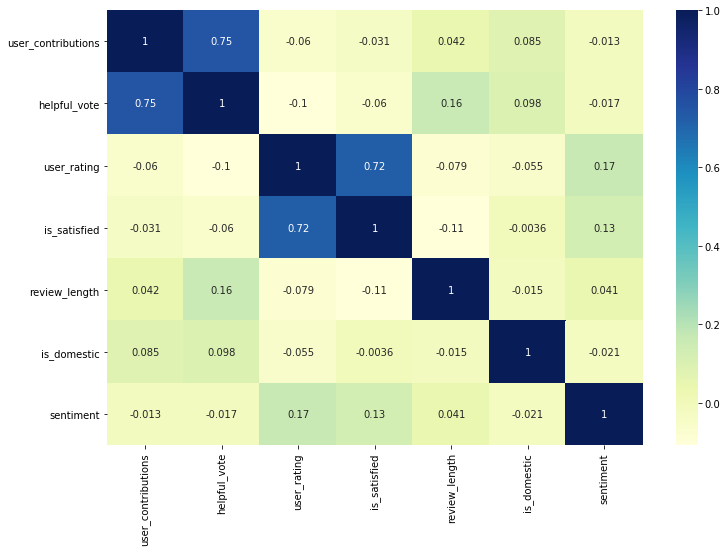

In [32]:
plot_corr(obe_df)

### Reviews with negative sentiment but good rating (4, 5): 

#### These are reviews that may go overlooked because they are masked by a good rating, or are mislabeled false positives.

In [33]:
get_neg_reviews(obe_df, -1, 1)


--Review--

Date Posted: 2018-07-26 00:00:00
Rating: 5.0
Trip Type: business
Impact: 0
User Country: nan

Having spent a good number of days over the past few decades at The Oberoi Mumbai I can only say the exemplary standards of service are an industry benchmark that very few hotels worldwide can claim to have achieved.The Gold standard in personalised service and attention to detail.


--Review--

Date Posted: 2016-03-22 00:00:00
Rating: 4.0
Trip Type: business
Impact: 1
User Country: India

I may be a little late to post my review but my recent visit to the other oberoi hotel in Gurgaon made me compare the service . I was on a nights stay somewhere in Jan I guess in oberoi mumbai and was met by the front desk manager . When I mentioned that how come Internet was chargeable she mentioned she'll get it included and I felt grateful as it felt like petty thing. But the very next day i was being charged for it .when I informed the cashier that the front desk manager Behnaz had promised 

### Reviews with bad sentiment and bad rating (3 and below):

In [34]:
get_neg_reviews(obe_df)


--Review--

Date Posted: 2016-11-13 00:00:00
Rating: 2.0
Trip Type: business
Impact: 1
User Country: Malaysia

Ridiculously overpriced hotel , the basic needs are not available in the room .The reception staff are not “listening” to the guest , poor communications within your front office units.Creates confusions during check out .


--Review--

Date Posted: 2016-04-28 00:00:00
Rating: 1.0
Trip Type: business
Impact: 29
User Country: Singapore

Rooms are old and small. The walls are so thin and very noisy. Almost impossible to get away from that "slamming of the doors". Worst is when you complain about the noise, no one can help or is willing to help. Shower is super small and very old. There are much better and newer choices in Mumbai for the same price. Avoid!


--Review--

Date Posted: 2016-02-17 00:00:00
Rating: 3.0
Trip Type: business
Impact: 62
User Country: Israel

This is the worst 5 star hotel I've stayed in India and worse than some of the 4 star hotels. The location is ok. 

In [35]:
# obe_df.to_excel("D:\\DataSets\\trip_advisor\\The_Oberoi_Mumbai.xlsx")
# taj_df.to_excel("D:\\DataSets\\trip_advisor\\taj_mahal_palace_mumbai.xlsx")
# main_df.to_excel("D:\\DataSets\\trip_advisor\\combined.xlsx")